# DiT Image Generation Test Notebook

Use this notebook to quickly verify recent model changes (e.g., newly added residual connections) by sampling images from a DiT checkpoint.

**Important for Colab users:** This notebook clones the original DiT repo from GitHub. To test your local modifications:
1. Upload your modified `models.py` to Colab after running Cell 1, OR
2. Run this notebook locally with Jupyter instead



In [9]:
import os
import sys

# Detect environment and setup paths
in_colab = 'google.colab' in sys.modules
print(f"Running in: {'Google Colab' if in_colab else 'Local environment'}")

if in_colab:
    # Clone the repo if in Colab
    if not os.path.exists('/content/DiT'):
        print("Cloning DiT repository...")
        import subprocess
        subprocess.run(['git', 'clone', 'https://github.com/mrmc-speco/DiT.git'], cwd='/content')
    
    # Change to DiT directory
    os.chdir('/content/DiT')
    
    # Install dependencies
    print("Installing dependencies...")
    import subprocess
    subprocess.run([sys.executable, '-m', 'pip', 'install', '-q', 'diffusers', 'timm'])
    
    repo_root = '/content/DiT'
else:
    # Local environment - assume we're in the DiT directory
    repo_root = os.getcwd()
    # If models.py is not in current dir, try parent
    if not os.path.exists(os.path.join(repo_root, 'models.py')):
        repo_root = os.path.dirname(repo_root)

# Add to Python path
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

print(f"Repository root: {repo_root}")
print(f"Current working directory: {os.getcwd()}")

# Verify the path is correct
if os.path.exists(os.path.join(repo_root, 'models.py')):
    print("✓ Repository root found successfully")
else:
    print(f"\n⚠️  WARNING: models.py not found at {repo_root}")

import torch
from torchvision.utils import save_image

from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from download import find_model
from models import DiT_models
from PIL import Image
from IPython.display import display

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Running in: Google Colab
Installing dependencies...
Repository root: /content/DiT
Current working directory: /content/DiT
✓ Repository root found successfully
Using device: cuda


## Optional: Upload Modified models.py (Colab only)

If you're in Colab and want to test your local modifications, run this cell to upload your modified `models.py` file:


In [10]:
# # Patch models.py with skip connection (Colab only)
# import sys

# in_colab = 'google.colab' in sys.modules

# if in_colab:
#     print("Applying skip connection patch to models.py...")
    
#     # Use sed-like approach to patch the file
#     import subprocess
    
#     # Create a Python script to patch the file
#     patch_script = '''
# import re

# with open('/content/DiT/models.py', 'r') as f:
#     content = f.read()

# # Check if already patched
# if 'skip = x' in content and 'preserve pre-block representation' in content:
#     print("✓ Skip connection already applied!")
# else:
#     # Patch forward method
#     pattern = r"(def forward\\(self, x, t, y\\):.*?\\\"\\\"\\\"\\n)"
#     replacement = r'\\1        # Log forward pass\\n        print(f"[DiT Forward] Batch: {x.shape}, Timesteps: [{t.min().item():.0f}-{t.max().item():.0f}]")\\n        '
#     content = re.sub(pattern, replacement, content, flags=re.DOTALL)
    
#     # Add skip connection
#     pattern = r"(c = t \\+ y.*?# \\(N, D\\)\\n)        (for block in self\\.blocks:)"
#     replacement = r"\\1        skip = x  # preserve pre-block representation\\n        \\2"
#     content = re.sub(pattern, replacement, content)
    
#     pattern = r"(for block in self\\.blocks:.*?x = block\\(x, c\\).*?\\n)        (x = self\\.final_layer)"
#     replacement = r"\\1        x = x + skip  # skip connection\\n        print(f'[DiT Forward] ✓ Skip applied across {len(self.blocks)} blocks')\\n        \\2"
#     content = re.sub(pattern, replacement, content, flags=re.DOTALL)
    
#     with open('/content/DiT/models.py', 'w') as f:
#         f.write(content)
    
#     print("✓ Patch applied!")
# '''
    
#     with open('/tmp/patch.py', 'w') as f:
#         f.write(patch_script)
    
#     result = subprocess.run(['python', '/tmp/patch.py'], capture_output=True, text=True)
#     print(result.stdout)
    
#     if result.returncode == 0:
#         print("⚠️  Please restart runtime (Runtime > Restart runtime) and re-run all cells")
#     else:
#         print(f"Error: {result.stderr}")
# else:
#     print("Not in Colab - skipping patch")


In [11]:
# --- Configuration ---------------------------------------------------------
model_key = "DiT-XL/2"      # Choose from models.DiT_models
image_size = 256             # 256 or 512 for auto-downloaded checkpoints
vae_variant = "ema"          # "mse" or "ema" (Stable Diffusion VAE variants)
num_sampling_steps = 9     # More steps -> better quality, slower
cfg_scale = 4.0
class_labels = [387]  # ImageNet class IDs
samples_per_row = 1
seed = 0
custom_ckpt = None          # Optional path to a custom DiT checkpoint
# ---------------------------------------------------------------------------

torch.manual_seed(seed)
latent_size = image_size // 8

if custom_ckpt is None:
    if model_key != "DiT-XL/2":
        raise ValueError("Automatic checkpoints are only available for DiT-XL/2. Provide custom_ckpt instead.")
    ckpt_path = f"DiT-XL-2-{image_size}x{image_size}.pt"
else:
    ckpt_path = custom_ckpt

print(f"Loading {model_key} from {ckpt_path}")
model = DiT_models[model_key](input_size=latent_size).to(device)
state_dict = find_model(ckpt_path)
model.load_state_dict(state_dict)
model.eval()

diffusion = create_diffusion(str(num_sampling_steps))
vae = AutoencoderKL.from_pretrained(f"stabilityai/sd-vae-ft-{vae_variant}").to(device)


Loading DiT-XL/2 from DiT-XL-2-256x256.pt
Creating DiT-XL/2 model...



Starting sampling process...
Will run 9 diffusion steps
Watch for [DiT CFG] and [DiT Forward] log messages below:


[CFG] Input: torch.Size([2, 4, 32, 32]), CFG scale: 4.0
[DiT Forward] Batch: torch.Size([2, 4, 32, 32]), Timesteps: [999-999], Classes: [387, 1000]
[DiT Forward] ✓ Skip connection applied across 28 blocks
[CFG] ✓ Guidance applied, output: torch.Size([2, 8, 32, 32])


[CFG] Input: torch.Size([2, 4, 32, 32]), CFG scale: 4.0
[DiT Forward] Batch: torch.Size([2, 4, 32, 32]), Timesteps: [874-874], Classes: [387, 1000]
[DiT Forward] ✓ Skip connection applied across 28 blocks
[CFG] ✓ Guidance applied, output: torch.Size([2, 8, 32, 32])


[CFG] Input: torch.Size([2, 4, 32, 32]), CFG scale: 4.0
[DiT Forward] Batch: torch.Size([2, 4, 32, 32]), Timesteps: [749-749], Classes: [387, 1000]
[DiT Forward] ✓ Skip connection applied across 28 blocks
[CFG] ✓ Guidance applied, output: torch.Size([2, 8, 32, 32])


[CFG] Input: torch.Size([2, 4, 32, 32]), CFG scale: 4.0
[DiT Forward] Batch: to

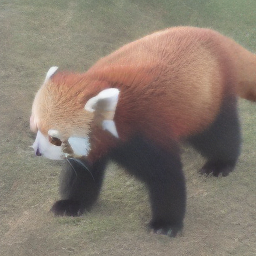

In [12]:
n = len(class_labels)
z = torch.randn(n, 4, latent_size, latent_size, device=device)
y = torch.tensor(class_labels, device=device)

# Classifier-free guidance setup:
z = torch.cat([z, z], dim=0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], dim=0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)

print("\n" + "="*60)
print("Starting sampling process...")
print(f"Will run {num_sampling_steps} diffusion steps")
print("Watch for [DiT CFG] and [DiT Forward] log messages below:")
print("="*60 + "\n")

samples = diffusion.p_sample_loop(
    model.forward_with_cfg,
    z.shape,
    z,
    clip_denoised=False,
    model_kwargs=model_kwargs,
    progress=False,  # Disable tqdm to see our prints clearly
    device=device,
)

print("\n" + "="*60)
print("Sampling complete! Decoding with VAE...")
print("="*60 + "\n")

samples, _ = samples.chunk(2, dim=0)
samples = vae.decode(samples / 0.18215).sample

output_path = "dit_test_samples.png"
save_image(samples, output_path, nrow=samples_per_row, normalize=True, value_range=(-1, 1))
print(f"✓ Saved grid to {output_path}")
display(Image.open(output_path))
